<a href="https://colab.research.google.com/github/vishalrk1/SkimLit/blob/main/skimlit_20K_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

**The purpose of this project is to build an NLP Model to make reading medical abstract easier**



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

## Get Data

* Downloading dataset [PubMed RCT200K from Github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os

filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# **Preprocessing Data**

* function to read in all of the lines of target text files

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

* Converting each sentence in the list of dictionary from text file

In [ ]:
def preprocess_text_with_line_number(filename):
  """
  returns a list of dictionary of lines data
  
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
    
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
       abstract_lines += line

  return abstract_samples

In [ ]:
# getting data from file and preocess it
train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')

In [ ]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

* Converting list of dictionaries in pandas dataframe

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


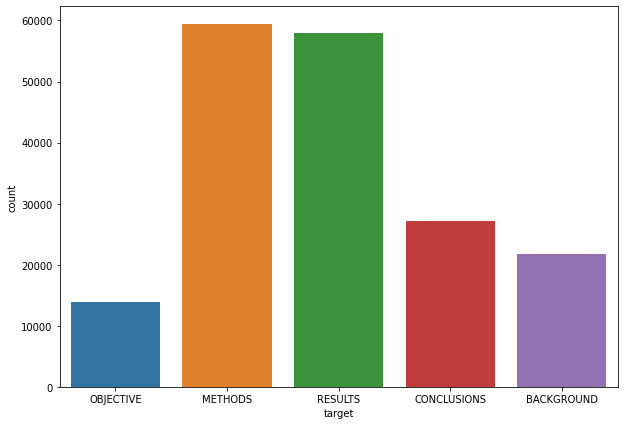

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot('target',data=train_df);

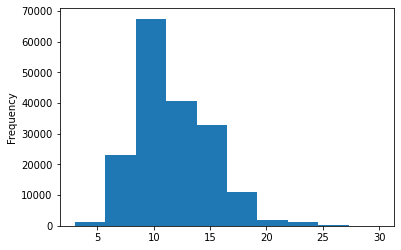

In [ ]:
train_df['total_lines'].plot.hist()

## List of sentences

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#Making Numeric labels

* one hot encoded labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

* Label Incoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

##class names and number of classes

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#Useful Functions

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accurecy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

In [ ]:

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2021-10-13 04:55:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-13 04:55:01 (73.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Bulding Models

## 1. NaiveBase Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
model_0 = Pipeline([
    ('tfifd', TfidfVectorizer()),
    ('NB', MultinomialNB()), 
])

In [ ]:
model_0.fit(train_sentences, train_label_encoded)

Pipeline(memory=None,
         steps=[('tfifd',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('NB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
model_0.score(val_sentences, val_label_encoded)

0.7218323844829869

In [ ]:
model_0_pred = model_0.predict(val_sentences)

In [ ]:
baseline_result = calculate_result(val_label_encoded, model_0_pred)
baseline_result

{'accurecy': 0.7218323844829869,
 'f1-score': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing Embedding Layer

In [ ]:
from tensorflow.keras.layers import TextVectorization, Embedding

* Average sentence length

In [ ]:
sent_len = round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))
sent_len

26

### Text vectorizor

* **max_vocab_length** for 20k dataset is 68k
* **max_vocab_length** for 200k dataset is 331k

In [ ]:
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Embedding Layer

In [ ]:
embedding = Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero=True,
    name='token_embedding'
)

### Turning our data into tensorflow datasets

* tensorflow data api

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

* take tensorflow dataset and prefetch them into prefetched dataset

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## 2. Conv1D layer

In [ ]:
num_classes

5

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(
    filters = 64,
    kernel_size = 5,
    padding = 'same',
    activation = 'relu',
)(x)

x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
model_1.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325

In [ ]:
model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

history_1 = model_1.fit(
    train_dataset,
    epochs = 5,
    steps_per_epoch = len(train_dataset),
    validation_data = val_dataset,
    validation_steps = int(0.15 * len(val_dataset)),
)

Epoch 1/5
5627/5627 [==============================] - 101s 13ms/step - loss: 0.5463 - accuracy: 0.7977 - val_loss: 0.4646 - val_accuracy: 0.8262
Epoch 2/5
5627/5627 [==============================] - 75s 13ms/step - loss: 0.3577 - accuracy: 0.8711 - val_loss: 0.5343 - val_accuracy: 0.8125
Epoch 3/5
5627/5627 [==============================] - 76s 13ms/step - loss: 0.2181 - accuracy: 0.9242 - val_loss: 0.6539 - val_accuracy: 0.7983
Epoch 4/5
5627/5627 [==============================] - 75s 13ms/step - loss: 0.1231 - accuracy: 0.9591 - val_loss: 0.8432 - val_accuracy: 0.7855
Epoch 5/5
5627/5627 [==============================] - 76s 13ms/step - loss: 0.0768 - accuracy: 0.9744 - val_loss: 0.9769 - val_accuracy: 0.7928


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 1.0134 - accuracy: 0.7893


[1.013449788093567, 0.7892559170722961]

In [ ]:
model_1_pred = tf.squeeze(tf.round(model_1.predict(val_dataset)))

In [ ]:
model_1_pred = tf.argmax(model_1_pred, axis=1)

In [ ]:
model_1_result = calculate_result(val_label_encoded, model_1_pred)
model_1_result

{'accurecy': 0.7881967430160202,
 'f1-score': 0.7873159476850312,
 'precision': 0.7894156623871118,
 'recall': 0.7881967430160202}

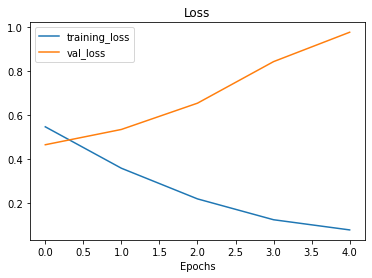

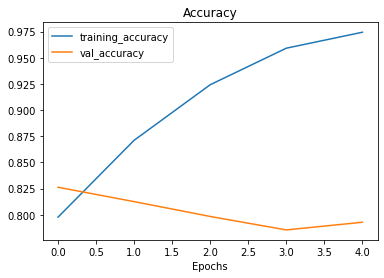

In [ ]:
plot_loss_curves(history_1)

## 3. Feature extraction with pretrained token embedding

* Universal sentence embedding

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy'],
)

history_2 = model_2.fit(
    train_dataset,
    epochs = 5,
    steps_per_epoch = len(train_dataset),
    validation_data = val_dataset,
    validation_steps = int(0.15 * len(val_dataset)),
)

Epoch 1/5
5627/5627 [==============================] - 103s 18ms/step - loss: 0.7307 - accuracy: 0.7211 - val_loss: 0.6483 - val_accuracy: 0.7542
Epoch 2/5
5627/5627 [==============================] - 101s 18ms/step - loss: 0.6372 - accuracy: 0.7585 - val_loss: 0.6122 - val_accuracy: 0.7706
Epoch 3/5
5627/5627 [==============================] - 101s 18ms/step - loss: 0.6020 - accuracy: 0.7725 - val_loss: 0.5970 - val_accuracy: 0.7768
Epoch 4/5
5627/5627 [==============================] - 102s 18ms/step - loss: 0.5791 - accuracy: 0.7813 - val_loss: 0.5917 - val_accuracy: 0.7762
Epoch 5/5
5627/5627 [==============================] - 102s 18ms/step - loss: 0.5619 - accuracy: 0.7882 - val_loss: 0.5898 - val_accuracy: 0.7764


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.5984 - accuracy: 0.7717


[0.5983991622924805, 0.7717131972312927]

In [ ]:
model_2_pred = tf.squeeze(tf.round(model_2.predict(val_dataset)))

In [ ]:
model_2_pred = tf.argmax(model_2_pred, axis=1)

In [ ]:
model_2_result = calculate_result(val_label_encoded, model_2_pred)
model_2_result

{'accurecy': 0.7578114656427909,
 'f1-score': 0.7598245385783718,
 'precision': 0.7839052430566683,
 'recall': 0.7578114656427909}

# **Character level Tokeninzer**

* Function to split sentences into characters

In [ ]:
def split_character(text):
  return ' '.join(list(text))

In [ ]:
split_character('I love Tensorflow')

'I   l o v e   T e n s o r f l o w'

* Appling split function to all datasets

In [ ]:
train_chars = [split_character(sentences) for sentences in train_sentences]
val_chars = [split_character(sentences) for sentences in val_sentences]
test_chars = [split_character(sentences) for sentences in test_sentences]

* Average character length

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

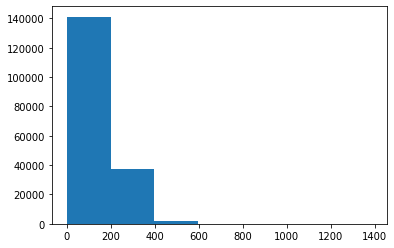

In [ ]:
plt.hist(char_lens, bins=7);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

* Character Level Tokenizer

In [ ]:
NUM_CHAR_TOKEN = len(alphabet) + 2

char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKEN,
    output_sequence_length = output_seq_char_len,
)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


# Character level Embedding layer

In [ ]:
char_embedding = Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    mask_zero = True,
    name = 'char_embed'
)

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

In [ ]:
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## 4. Conv1D Model with char level Embedding

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(
    filters = 64,
    kernel_size = 5,
    padding = 'same',
    activation= 'relu',
)(x)

x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)

In [ ]:
model_3.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325

In [ ]:
model_3.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy'],
)

history_3 = model_3.fit(
    train_char_dataset,
    epochs = 3,
    steps_per_epoch = len(train_char_dataset),
    validation_data = val_char_dataset,
    validation_steps = int(0.15 * len(val_char_dataset)),
)

Epoch 1/3
5627/5627 [==============================] - 54s 9ms/step - loss: 0.8663 - accuracy: 0.6587 - val_loss: 0.7452 - val_accuracy: 0.7150
Epoch 2/3
5627/5627 [==============================] - 53s 9ms/step - loss: 0.7338 - accuracy: 0.7183 - val_loss: 0.7139 - val_accuracy: 0.7301
Epoch 3/3
5627/5627 [==============================] - 53s 9ms/step - loss: 0.6936 - accuracy: 0.7374 - val_loss: 0.6939 - val_accuracy: 0.7409


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.7095 - accuracy: 0.7328


[0.7094933986663818, 0.7328214049339294]

In [ ]:
model_3_pred = tf.squeeze(tf.round(model_3.predict(val_char_dataset)))

model_3_pred = tf.argmax(model_3_pred, axis=1)

model_3_result = calculate_result(val_label_encoded, model_3_pred)
model_3_result

{'accurecy': 0.7231563617105786,
 'f1-score': 0.7208938667649313,
 'precision': 0.7486215626590199,
 'recall': 0.7231563617105786}

## 5.  Combining pretrained token embedding and character level embedding

In [ ]:
# token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Charater imputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Concat layer 
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                             char_model.output])

# output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dence = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dence)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

In [ ]:
# model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer
)

In [ ]:
model_4.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
___________________________________________________________________________________________

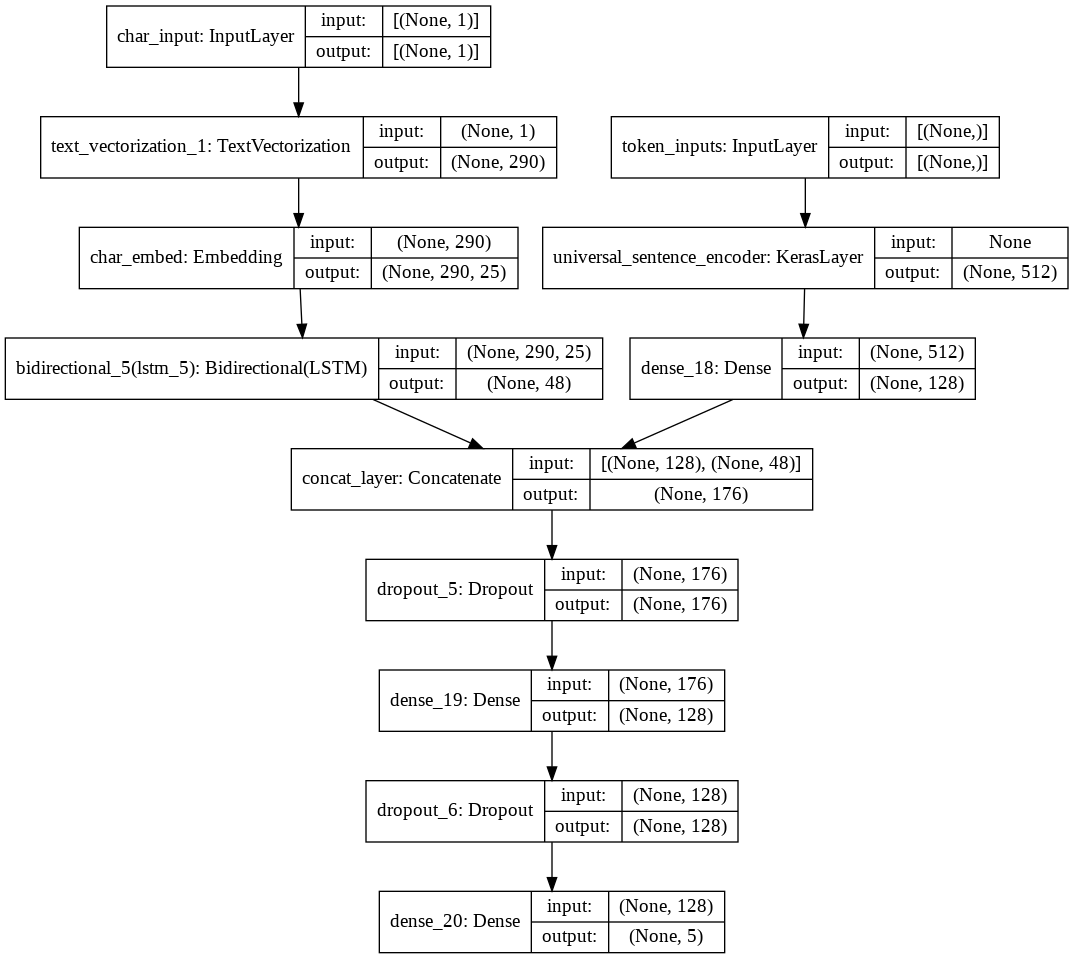

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(
    loss='categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

### Combining token and character data 

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [ ]:
history_4 = model_4.fit(
    train_char_token_dataset,
    epochs = 3,
    steps_per_epoch = len(train_char_token_dataset),
    validation_data = val_char_token_dataset,
    validation_steps = int(0.15 * len(val_char_token_dataset)),
)

Epoch 1/3
5627/5627 [==============================] - 698s 122ms/step - loss: 0.7598 - accuracy: 0.7101 - val_loss: 0.6112 - val_accuracy: 0.7702
Epoch 2/3
5627/5627 [==============================] - 687s 122ms/step - loss: 0.6741 - accuracy: 0.7463 - val_loss: 0.5869 - val_accuracy: 0.7757
Epoch 3/3
5627/5627 [==============================] - 687s 122ms/step - loss: 0.6499 - accuracy: 0.7558 - val_loss: 0.5726 - val_accuracy: 0.7883


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.5829 - accuracy: 0.7802


[0.5829356908798218, 0.7802197933197021]

In [ ]:
model_4_pred = tf.squeeze(tf.round(model_4.predict(val_char_token_dataset)))

model_4_pred = tf.argmax(model_4_pred, axis=1)

model_4_result = calculate_result(val_label_encoded, model_4_pred)
model_4_result

{'accurecy': 0.7644644512114391,
 'f1-score': 0.766841070290941,
 'precision': 0.7897090429541196,
 'recall': 0.7644644512114391}

In [ ]:
model_1_result

{'accurecy': 0.7881967430160202,
 'f1-score': 0.7873159476850312,
 'precision': 0.7894156623871118,
 'recall': 0.7881967430160202}

# Positional Embedding Layer

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


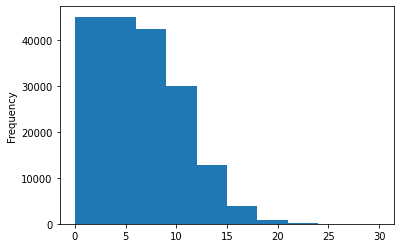

In [ ]:
train_df['line_number'].plot.hist();

In [ ]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)


train_line_number_one_hot[:5], train_line_number_one_hot.shape

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

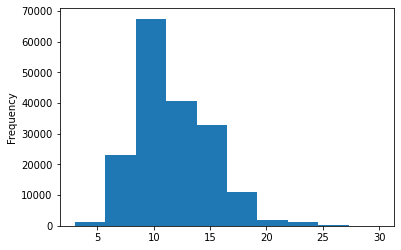

In [ ]:
train_df['total_lines'].plot.hist();

In [ ]:
train_total_line_number_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_number_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_number_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


train_total_line_number_one_hot[:5], train_line_number_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>, TensorShape([180040, 15]))

## Model with token, character and positional embedding layers

In [ ]:
train_line_number_one_hot[0].shape, train_line_number_one_hot[0].dtype

(TensorShape([15]), tf.float32)

In [ ]:
train_total_line_number_one_hot[0].shape, train_total_line_number_one_hot[0].dtype

(TensorShape([20]), tf.float32)

In [ ]:
# 1. token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Charater imputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. model for line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_numbers_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs) 

# 4. model for total_line feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

# 5. Concat layer 1 & 2
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                             char_model.output])

# adding one dropout layer
z = layers.Dense(256, activation='relu')(token_char_concat)
z = layers.Dropout(0.5)(z)

# 6. concat layers 3 4 5
final_concat = layers.Concatenate(name='final_concat')([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_concat)

# final model
model_5 = tf.keras.Model(
    inputs = [
              line_number_model.input,
              total_lines_model.input,
              token_model.input,
              char_model.input,
    ],
    outputs = output_layer
)

In [ ]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________________________

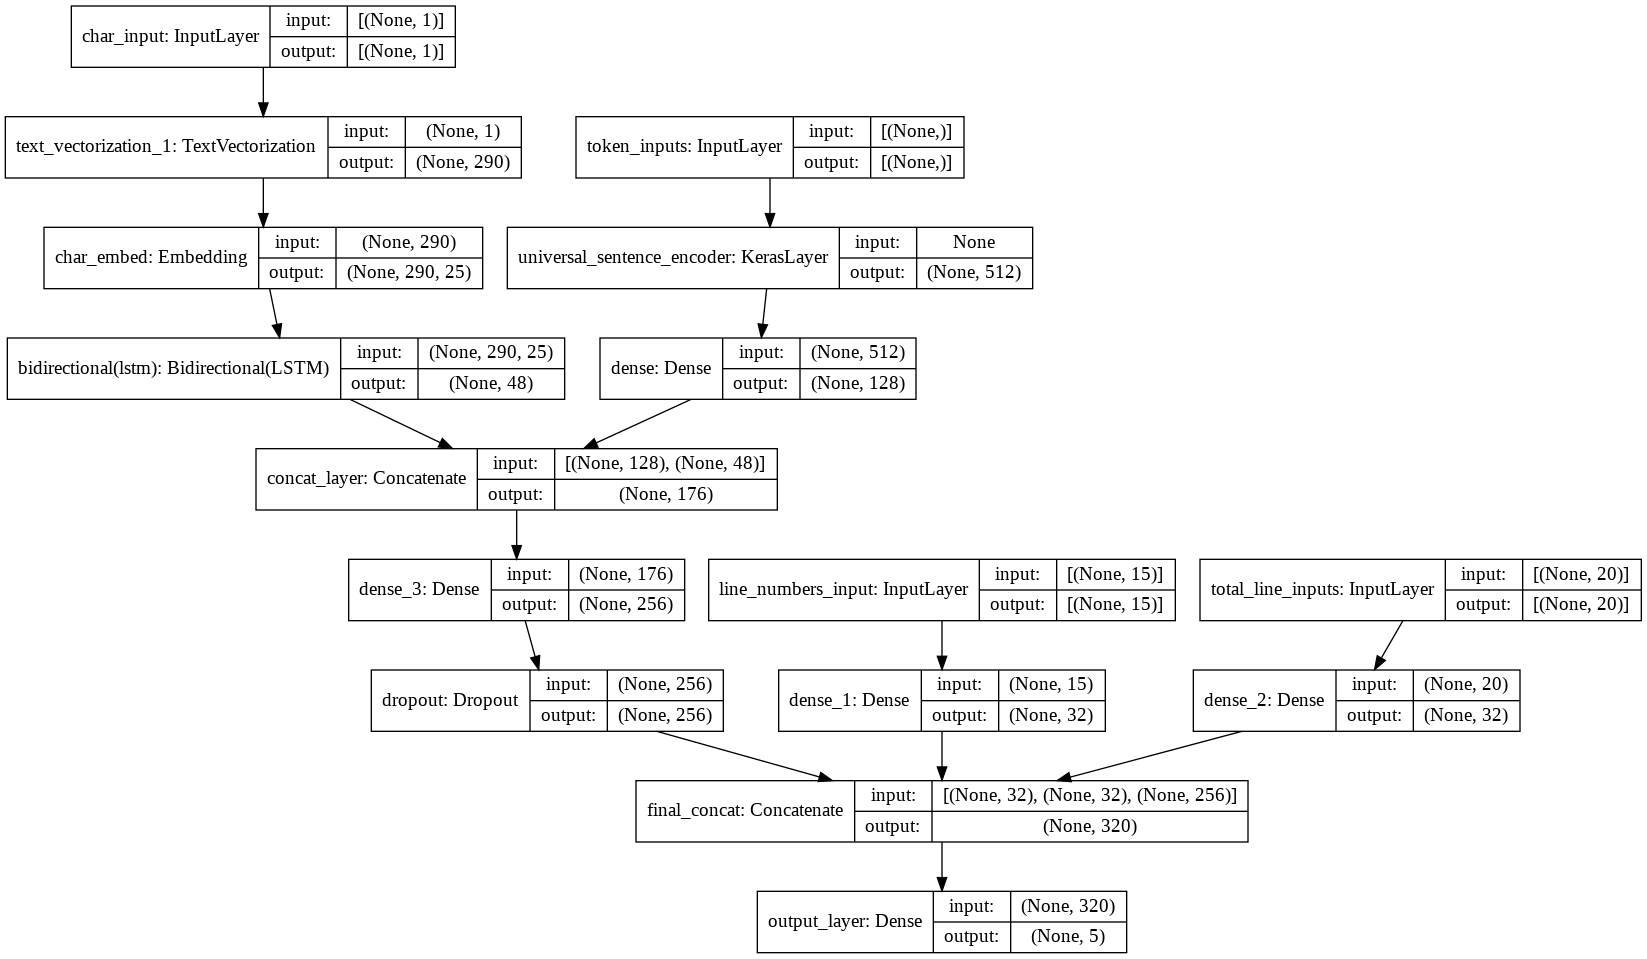

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = Adam(),
    metrics = ['accuracy']
)

### Creating tribrid inputs

In [ ]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_line_number_one_hot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_line_number_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot, test_total_line_number_one_hot, test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_5 = model_5.fit(
    train_tribrid_dataset,
    epochs = 5,
    steps_per_epoch = len(train_tribrid_dataset),
    validation_data = val_tribrid_dataset,
    validation_steps = int(0.15 * len(val_tribrid_dataset)),
)

Epoch 1/5
5627/5627 [==============================] - 709s 123ms/step - loss: 0.9538 - accuracy: 0.8231 - val_loss: 0.9027 - val_accuracy: 0.8504
Epoch 2/5
5627/5627 [==============================] - 688s 122ms/step - loss: 0.9094 - accuracy: 0.8533 - val_loss: 0.8943 - val_accuracy: 0.8557
Epoch 3/5
5627/5627 [==============================] - 681s 121ms/step - loss: 0.8974 - accuracy: 0.8626 - val_loss: 0.8907 - val_accuracy: 0.8604
Epoch 4/5
5627/5627 [==============================] - 685s 122ms/step - loss: 0.8890 - accuracy: 0.8689 - val_loss: 0.8901 - val_accuracy: 0.8575
Epoch 5/5
5627/5627 [==============================] - 680s 121ms/step - loss: 0.8823 - accuracy: 0.8740 - val_loss: 0.8901 - val_accuracy: 0.8586


In [ ]:
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.8953 - accuracy: 0.8565


[0.8953065276145935, 0.8565139770507812]

In [ ]:
model_5_pred = tf.squeeze(tf.round(model_5.predict(val_tribrid_dataset)))

model_5_pred = tf.argmax(model_5_pred, axis=1)

model_5_result = calculate_result(val_label_encoded, model_5_pred)
model_5_result

{'accurecy': 0.8150403813054415,
 'f1-score': 0.8234978020888051,
 'precision': 0.8685746294826409,
 'recall': 0.8150403813054415}

# Comparing results of all models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_result,
                                  "custom_token_embed_conv1d": model_1_result,
                                  "pretrained_token_embed": model_2_result,
                                  "custom_char_embed_conv1d": model_3_result,
                                  "hybrid_char_token_embed": model_4_result,
                                  "tribrid_pos_char_token_embed": model_5_result})
all_model_results = all_model_results.transpose()
all_model_results.to_csv('model_results.csv')
all_model_results

,accurecy,precision,recall,f1-score
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.788197,0.789416,0.788197,0.787316
pretrained_token_embed,0.757811,0.783905,0.757811,0.759825
custom_char_embed_conv1d,0.723156,0.748622,0.723156,0.720894
hybrid_char_token_embed,0.764464,0.789709,0.764464,0.766841
tribrid_pos_char_token_embed,0.815040,0.868575,0.815040,0.823498


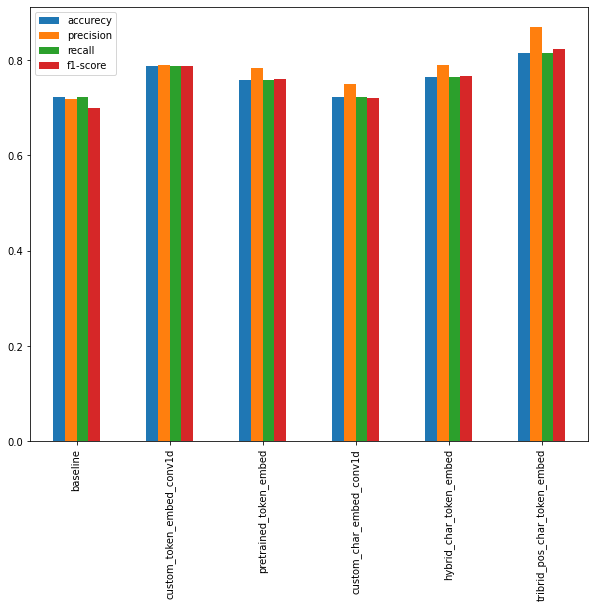

In [ ]:
all_model_results.plot(kind='bar', figsize=(10,8))

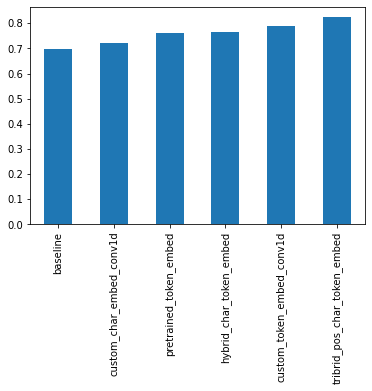

In [ ]:
all_model_results['f1-score'].sort_values().plot(kind='bar');

# Saving Model

In [ ]:
model_5.save('Skimlit_20k_model')

INFO:tensorflow:Assets written to: Skimlit_20k_model/assets


INFO:tensorflow:Assets written to: Skimlit_20k_model/assets


In [ ]:
!zip -r /content/skimlit_20K_model.zip /content/Skimlit_20k_model

  adding: content/Skimlit_20k_model/ (stored 0%)
  adding: content/Skimlit_20k_model/variables/ (stored 0%)
  adding: content/Skimlit_20k_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/Skimlit_20k_model/variables/variables.index (deflated 77%)
  adding: content/Skimlit_20k_model/assets/ (stored 0%)
  adding: content/Skimlit_20k_model/saved_model.pb (deflated 77%)
  adding: content/Skimlit_20k_model/keras_metadata.pb (deflated 91%)


In [ ]:
loaded_model = tf.keras.models.load_model('Skimlit_20k_model')

ValueError: ignored

In [ ]:
model_5.evaluate(test_tribrid_dataset)

942/942 [==============================] - 52s 55ms/step - loss: 0.9134 - accuracy: 0.8481


[0.9133615493774414, 0.8480836153030396]